# Setup

In [221]:
# Install the required python library with pip
!pip install control==0.10.0

import numpy as np
import control as cp
import matplotlib.pyplot as plt

# Task 1: Modern Control Synthesis

In this task you will learn how you can use the `control` library to set up your plants for synthesizing a controller. To express performance and stabity contraints you will create frequency weights and compute the augmented generalized plant that can be further used with various methods to synthesize a controller.

## Plant definition

The plant use in this task models the linearized behavior of a simple inverted pendulum an is given as $$P(s) = \frac{1}{s^2+0.1s-9.81}.$$
Note that this plant is unstable and we will need use a controller.

Initially we define our controller $C(s)$ to do nothing, i.e. $$C(s) = 1.$$


In [203]:
P_s = ct.TransferFunction([1], [1, 0.1, -9.81], input='u', output='y', name='P(s)')
C_s = ct.TransferFunction([1], [1], input='e', output='u', name='C(s)')

print("Plant transfer function:")
display(P_s)
print("\nController transfer function:")
display(C_s)

Plant transfer function:


TransferFunction(array([1]), array([ 1.  ,  0.1 , -9.81]))


Controller transfer function:


TransferFunction(array([1]), array([1]))

And we can easily check stability with `ct.poles` and see that the plant is unstable and has a pole with negative real part.

In [192]:
ct.poles(P_s)

array([-3.18249102+0.j,  3.08249102+0.j])

## Frequency Weights

<img src="images/blockdiagram.png" alt="Block Diagram" width="600"/>


We want to create the two weights $W_1(s)$ and $W_3(s)$ to ensure reference tracking and noise attenuation.

Remember how we defined $W_1(s)$ and $W_3(s)$ in the lecture:
- $||W_1(s)S(s)|| << 1$ or $\sigma_{min}[L(s)] >> |W_1(s)|$
- $||W_3(s)T(s)|| <<$ 1 or $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$

Therefore we want $W_1(s)$ to have very large magnitudes at flow frequencies and $W_3(s)$ to have large magnitudes at high frequencies.

You first task is to implement functions that create our frequency weights with the definition from Lecutre 9:

$$ W_1(s) = \frac{M}{Ms/\omega_1 + 1} \quad \text{and} \quad W_3(s) = \frac{Ms}{s + M\omega_3}.



In [196]:
def makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([1], [1], name='W_1')


def makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([1], [1], name='W_3')

Solutions

In [197]:
# Solutions
def solution_makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.

    Parameters
    ----------
    - M (float): The desired DC gain of the transfer function.
    - w1 (float): The frequency at which the magnitude of the transfer function is 1.

    Returns
    -------
    TransferFunction: The frequency weight transfer function.

    """
    return ct.TransferFunction([M], [M/w1, 1], name='W_1')


def solution_makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.

    Parameters
    ----------
    - M (float): The magnitude of the frequency weighting
    - w3: The frequency at which the weighting starts to take effect

    Returns
    -------
    - tf: The transfer function representing the frequency-weighted system
    """

    return ct.TransferFunction([M, 0], [1, M*w3], name='W_3')

Now define the two weights such that:

- $W_1(s)$ has magnitude 100 at low frequencies, rolls off to zero at high frequency, and has magnitude 1 at frequency $\omega_1 = 0.1 \text{rad/s}$,
- $W_3(s)$ approaches magnitude 100 at high frequencies, has magnitude 1 at frequency $\omega_3 = 10\text{rad/s}$ and a zero DC gain.

In [198]:
W_1 = None
W_3 = None


# Solutions
solution_W_1 = solution_makeweight_1(100, 0.1)
solution_W_3 = solution_makeweight_3(100, 10)

# Test
assert W_1 == solution_W_1, "W_1 is incorrect"
assert W_3 == solution_W_3, "W_3 is incorrect"

AssertionError: W_1 is incorrect

## Visualization of Frequency weights

Now let us look at the singular value plots of these frequency weights and compare them to the open-loop transferfunction $L(s)$. Since we want $\sigma_{min}[L(s)] >> |W_1(s)|$ and $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$ We invert the $W_3(s)$

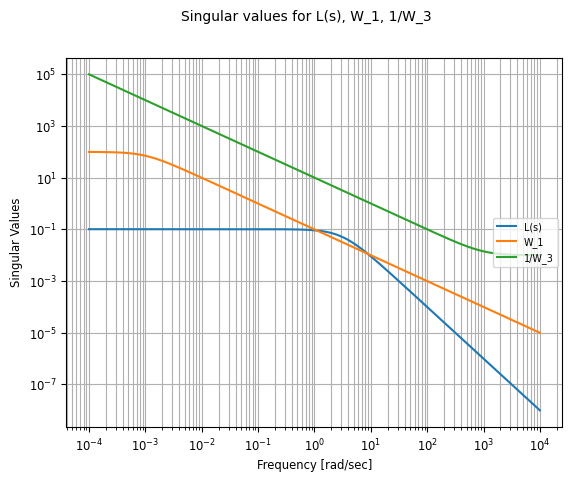

In [204]:
L_s = P_s * C_s
L_s.name = 'L(s)'

W_3_inverted = 1 / solution_W_3
W_3_inverted.name = '1/W_3'

_ = ct.singular_values_plot([L_s, solution_W_1, W_3_inverted])

## Assembly of the generalized plant

We want the open loop transfer function $L(s)$ to lie in between the upper and lower bound given by $W_1(s)$ and $W_3(s)$ respectively. Note that we are dealing with a SISO system and therefore get only one singular value implying $\sigma_{min}[L(s)] = \sigma_{max}[L(s)]$.

This loop shaping problem boils down to finding a controller $C(s)$ that places $L(s)$ in between our obstacles $W_1(s)$ and $W_3(s)$. We want to find the generalized plant 
$$ G(s) = \begin{bmatrix} G_{zw}(s) & G_{zu}(s) \\ G_{yw}(s) & G_{yu}(s) \end{bmatrix},$$

which we can then use in a optimization problem to synthesize our controller C(s).

One could derive each transfer function by hand and would find that

$$ G(s) = \begin{bmatrix} W_1(s) & -W_1(s)P(s) \\ 0 & W_3(s)P(s) \end{bmatrix},$$

or we can use the function `ct.augw(g, w1, w2, w3)` from the `control` library. \
**Caution:** due to a different nomenclature `g` corresponds to the plant $P(s)$ and **NOT** the generalized plant $G(s)$!


In [207]:
W2 = ct.tf([1], [1])
G_s = ct.augw(P_s, w1=solution_W_1, w2=W2, w3=solution_W_3)

display(G_s)

StateSpace(array([[-1.00e-03,  0.00e+00,  0.00e+00,  1.00e-01],
       [ 0.00e+00, -1.00e+03,  0.00e+00, -1.00e+01],
       [ 0.00e+00,  0.00e+00, -1.00e-01,  9.81e-01],
       [ 0.00e+00,  0.00e+00,  1.00e+01,  0.00e+00]]), array([[ 1.,  0.],
       [ 0.,  0.],
       [ 0., -1.],
       [ 0.,  0.]]), array([[ 1.e-01,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e+03,  0.e+00, -1.e+01],
       [ 0.e+00,  0.e+00,  0.e+00,  1.e-01]]), array([[0., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.]]))

Now we can use e.g. $H_2$ optimal control to synthesize our controller.

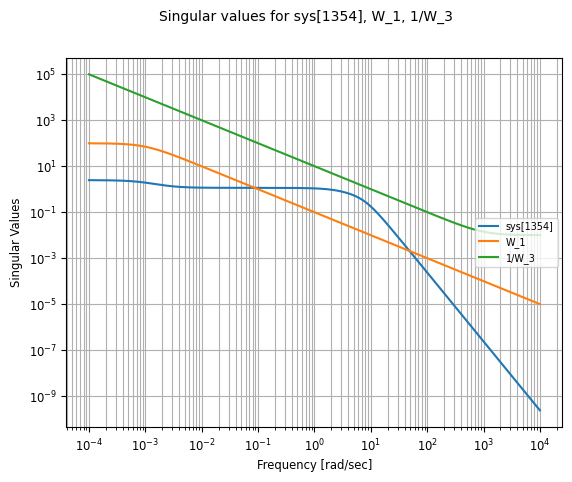

In [215]:
K_s = ct.h2syn(G_s, nmeas=1, ncon=1)
T = ct.feedback(P_s*K_s, sign=-1)

L_s = P_s * K_s

_ = ct.singular_values_plot([L_s, solution_W_1, W_3_inverted])

Now we can check the stability again and see

In [212]:
ct.poles(T)

array([-9.99999995e+02+0.j, -3.20377232e+00+0.j, -3.18249097e+00+0.j,
       -3.08249107e+00+0.j, -3.06198289e+00+0.j, -1.02427211e-02+0.j])

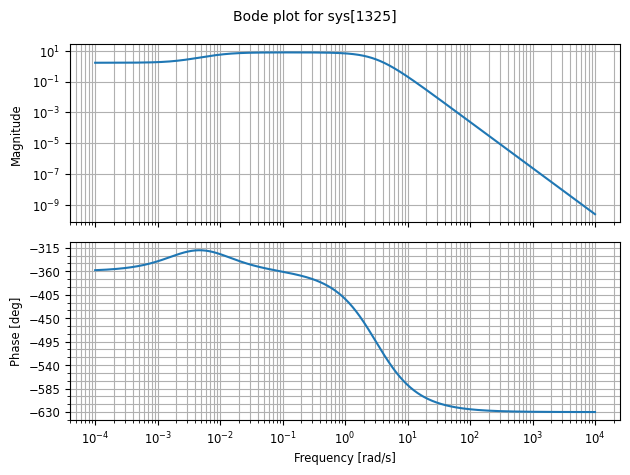

In [213]:
_ = ct.bode_plot(T)